Стандартное начало - подключение необходимых модулей, а также подключение модуля, дающего фотографии вин и данные по этим фото

In [49]:
import torch
import random
import numpy as np

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Разобьем данные на 2 части - обучающая и тестирующая выборка

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
    wine.data[:, :2],
    wine.target,
    test_size = 0.3,
    shuffle = True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Класс нейросети

SoftMax выдает вероятности для типа вида

In [47]:
class WineNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(WineNet, self).__init__()
    self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
    self.sm = torch.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

  def inference(self, x):
    x = self.forward(x)
    x = self.sm(x)
    return x

wine_net = WineNet(5)

Функция потерь и оптимизатор для данной нейросети

In [48]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr = 1.0e-3)

Начинаем обучение - в этот раз введем понятие "батч" - часть входных данных. Как раз по батчам размером 10 мы и разобьем наши данные

In [43]:
batch_size = 10

for epoch in range(2000):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    x_batch = X_train[batch_indexes]
    y_batch = y_train[batch_indexes]

    preds = wine_net.forward(x_batch)
    loss_val = loss(preds, y_batch)

    loss_val.backward()

    optimizer.step()

Визуализируем код


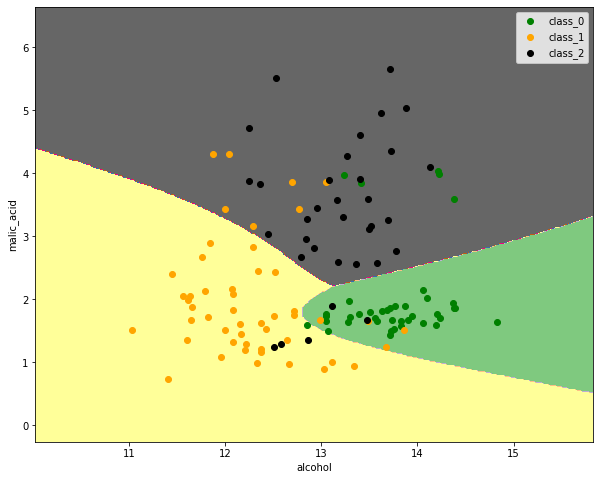

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['green', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()
